In [2]:
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap
%matplotlib inline
clustering_area = 'VOTING_PRECINCT'

In [3]:
# YOU MIGHT NEED TO INSTALL FOLIUM TO GET THIS TO RUN, USE ONE OF BELOW
#!pip install folium
# !conda install folium

# Descriptive Analysis & Clustering

This notebook will provide descriptive analysis for the felony crime data of Washinton DC from 2010 to 2018. The aim is to provide valuable and actionable insights into the distribution and nature of crime in the city. We start by summarizing types of crime over the period and providing an interractive heatmap showing the locations of crimes throughout the city highlighting hot-spots and problem areas. Then we will perform a clustering analysis of districts within the city to identify commonalities between different areas.

In [4]:
#Import Data
washington_loc = [38.907, -77.036]
crime_sets = dict()
for year in range(2010,2019):
    crime_sets[str(year)] = pd.read_csv('data/crime/USA_Crime_Incidents_in_{}.csv'.format(year))
    
crime_merged = pd.concat(crime_sets)
offense_types = list(set(crime_merged['OFFENSE']))
crime_merged.head()

X          Y      CCN                REPORT_DAT     SHIFT  \
2010 0 -76.975118  38.917289   100060  2010-07-16T14:00:00.000Z       DAY   
     1 -76.988297  38.927723  4172632  2010-01-21T00:00:00.000Z  MIDNIGHT   
     2 -76.957528  38.888178  6098962  2010-08-31T00:00:00.000Z  MIDNIGHT   
     3 -77.072294  38.921513  7151899  2010-09-14T00:00:00.000Z  MIDNIGHT   
     4 -76.995239  38.925427  9016047  2010-01-12T17:50:00.000Z   EVENING   

        METHOD                     OFFENSE  \
2010 0  OTHERS                THEFT F/AUTO   
     1     GUN                    HOMICIDE   
     2     GUN                    HOMICIDE   
     3  OTHERS                    HOMICIDE   
     4  OTHERS  ASSAULT W/DANGEROUS WEAPON   

                                           BLOCK    XBLOCK    YBLOCK  \
2010 0   1800 - 2299 BLOCK OF NEW YORK AVENUE NE  402158.0  138824.0   
     1       HAMLIN STREET NE AND 13TH STREET NE  401015.0  139982.0   
     2         100 - 199 BLOCK OF 34TH STREET SE  403685.0  135593.0   
     3  2301 - 2499 BLOCK OF WISCONSIN AVENUE NW  393731.0  139295.0   
     4     710 - 799 BLOCK OF EDGEWOOD STREET NE  400413.0  139727.0   

             ...        BLOCK_GROUP CENSUS_TRACT  VOTING_PRECINCT   LATITUDE  \
2010 0       ...           011100 3      11100.0      Precinct 72  38.917282   
     1       ...           009302 1       9302.0      Precinct 73  38.927715   
     2       ...           007708 1       7708.0     Precinct 132  38.888171   
     3       ...           000300 1        300.0      Precinct 11  38.921505   
     4       ...           009204 2       9204.0      Precinct 74  38.925419   

        LONGITUDE  BID                START_DATE                  END_DATE  \
2010 0 -76.975116  NaN  2010-07-15T13:37:00.000Z  2010-07-15T13:40:00.000Z   
     1 -76.988294  NaN  2004-12-19T00:45:00.000Z  2004-12-19T00:50:00.000Z   
     2 -76.957526  NaN  2006-07-23T01:40:00.000Z  2006-07-23T01:40:00.000Z   
     3 -77.072292  NaN  2007-11-03T20:12:00.000Z  2007-11-03T20:15:00.000Z   
     4 -76.995237  NaN  2010-01-11T19:51:00.000Z                       NaN   

         OBJECTID  OCTO_RECORD_ID  
2010 0  332101471     00100060-01  
     1  332101479     04172632-01  
     2  332101483     06098962-01  
     3  332101496     07151899-01  
     4  332138320     09016047-01  

[5 rows x 25 columns]

## Crime Location Heatmap


In [5]:

base_map = folium.Map(location=washington_loc, zoom_start=13)
heat_map = HeatMap(data=crime_merged[['Y', 'X', 'OFFENSE']].groupby(['Y', 'X']).count().reset_index().values.tolist(), radius=7, max_val=.2, max_zoom=15).add_to(base_map)
base_map.add_child(heat_map)
base_map

## Discussion
This heatmap shows the the location of all felony crimes recorded in Washinton DC during the period of interest. The interactive map shows problem areas and streets where there is a high concentration of crime. There is a greater density of crime overall near the city centre compared to the surrounding suburbs, however, there are patches of high crime evident throughout the area.

In [6]:
crime_merged['CRIME_DAY'] = pd.to_datetime(crime_merged['START_DATE']).dt.date
crime_merged = crime_merged[pd.to_datetime(crime_merged['CRIME_DAY']) >= pd.to_datetime('2010-01-01')]


In [7]:
# group by "VOTING_PRECINCT"
crime_grouped = crime_merged.groupby(by=[clustering_area,'OFFENSE']).agg({'CCN':'count'}).reindex()
crime_grouped.rename(columns={ 'CCN' : 'Count'}, inplace = True)

#pivot back to make offenses columns
crime_daily = crime_grouped.unstack(-1)
crime_daily.columns= crime_daily.columns.droplevel().fillna(0)

crime_update = crime_daily.fillna(0)
#crime_update.head()

## Co-Location of Offenses


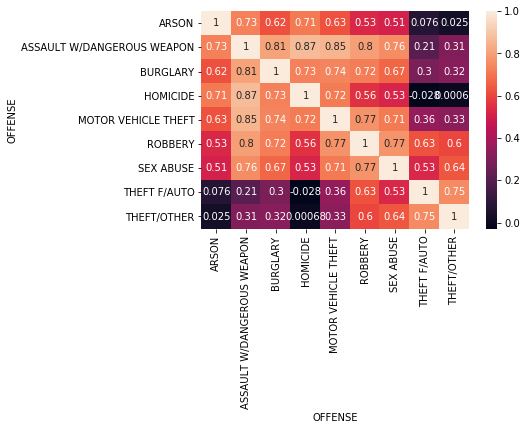

In [8]:
sns.heatmap(crime_update.corr(), annot = True) 
plt.show() 

## Discussion
This heatmap shows the correlations between the number of crimes of different types in Washington districts. A higher correlation value indicates that the crimes occur in the same neighbourhoods. There are a number of interesting features in this graph. First, the theft f/Auto and theft/other are mostly independent of the other categories. The strongest correlation appears between homicide and assault with a dangerous weapon, it makes sense that these crimes occur in the same districts as they both involve bodily harm.

In [13]:
from sklearn.cluster import KMeans 
clusters = 5
  
kmeans = KMeans(n_clusters = clusters, random_state=0) 
kmeans.fit(crime_update) 
  

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

## Identifying Cluster Characteristics

In [14]:
rainbow = ['red','blue','yellow','green','orange','purple','brown','black']

centers_df = pd.DataFrame(kmeans.cluster_centers_)
centers_df.columns = crime_update.columns[:]
centers_df['colour'] = rainbow[:len(centers_df)]
centers_df.index = centers_df['colour']
centers_df.drop(columns='colour', inplace=True)
for col in centers_df.columns:
    centers_df[col] = pd.cut(centers_df[col], 3, labels=['LOW', 'MEDIUM', 'HIGH'])
centers_df

OFFENSE,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER
colour,,,,,,,,,
red,LOW,LOW,LOW,MEDIUM,LOW,LOW,LOW,LOW,LOW
blue,LOW,HIGH,HIGH,LOW,HIGH,HIGH,HIGH,HIGH,HIGH
yellow,LOW,MEDIUM,HIGH,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM
green,LOW,LOW,MEDIUM,MEDIUM,LOW,LOW,LOW,LOW,LOW
orange,HIGH,LOW,MEDIUM,HIGH,MEDIUM,MEDIUM,MEDIUM,MEDIUM,LOW


In [15]:


def map_points(latitudes, longitudes, caption, clusters=None, rad=5, use_rainbow=True):
    if use_rainbow:
        use_colour = rainbow
    else:    
        use_colour = [colors.to_hex(cm.Reds(x)) for x in np.linspace(0,1,6)]
        
    map_clusters = folium.Map(location=washington_loc, zoom_start=12)
    if clusters is None:
        clusters = [0] * len(latitudes)

    for lat, lon, sub, clus in zip(latitudes, longitudes, caption, clusters):
        label = folium.Popup(str(sub), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=rad,
            popup=label,
            color=use_colour[clus],
            fill=True,
            fill_color=use_colour[clus],
            fill_opacity=0.4).add_to(map_clusters)
     
    return map_clusters

 ## Cluster Characteristics
 
* Red - Medium homicide, low in all other categories.
* Blue - High in assault, burglary, all types of theft, robbery and sex crime. Low in homicide.
* Yellow - High in burglary, medium in all other areas.
* Green - Medium burglary and homicide, low in all other categories.
* Orange - High homicide, medium burglary, robbery, vehicle theft, sex crime.

In [16]:
precinct_locs = crime_merged.groupby(by=[clustering_area]).agg({'X':'mean', 'Y':'mean'}).reindex()
precinct_locs = precinct_locs.fillna(0)
precinct_locs['cluster'] = kmeans.labels_

map_points(precinct_locs['Y'], precinct_locs['X'], precinct_locs.index, clusters=precinct_locs['cluster'])

## Interpretation
Here we can see many red districts spread around the outside of the city. These mostly suburban districs are low in all crime cateogories except homicide. Green districts are similarly low in crime but have higher burglary rates than red areas. Interestingly, the homicide crimes do not appear to be significantly concentrated in the urban areas, however, yellow, blue and orange clusters that are higher in theft and other types of crime are clearly more centralized.